In [84]:
import tensorflow as tf 
import matplotlib.pyplot as plt 
import numpy as np 
from glob import glob 
import random 
import os


In [85]:
data_dir = './20220303/archive' 

In [86]:
paths = '.'
images_path = os.path.join(paths, '20220303', 'archive', 'raw-img')

images = glob(images_path + '/*/*')

In [87]:
RES = 100 
N_CLASS = 10
BATCH_SIZE = 64

# 26179 images 
N_TRAIN = 20000
N_VAL = 6179 

In [102]:
# image = [] 
# label = []
# for img in images: 
#     img = 
#     label = img.split('\\')[-2]

images_ds = tf.keras.preprocessing.image_dataset_from_directory(
    images_path, 
    # validation_split=0.2,
    shuffle=True, 
    image_size=(RES, RES), 
    batch_size=BATCH_SIZE,
    label_mode = 'categorical'
)


train_size = int(0.7 * len(images_ds))

train_ds = images_ds.take(train_size)
val_ds = images_ds.skip(train_size)

Found 26179 files belonging to 10 classes.


In [103]:
# images_ds.prefetch(tf.data.AUTOTUNE)
# len(images_ds)
train_ds.prefetch(tf.data.AUTOTUNE)
val_ds.prefetch(tf.data.AUTOTUNE)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

C:\Users\krsty\AppData\Local\Programs\Python\Python39\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


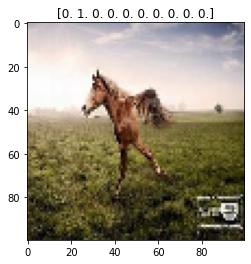

In [104]:
for img, label in images_ds.take(5):
    plt.imshow(img[0].numpy().astype('uint8'))
    plt.title(label[0].numpy()) 
    
plt.show()

In [105]:
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
mobilenetv3 = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(RES, RES, 3))

In [106]:
mobilenetv3.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 100, 100, 3)  0           ['input_5[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 50, 50, 16)   432         ['rescaling_2[0][0]']            
                                                                                                  
 Conv/BatchNorm (BatchNormaliza  (None, 50, 50, 16)  64          ['Conv[0][0]']    

In [107]:
def create_model():
    inputs = tf.keras.Input(shape=(RES, RES, 3))
    x = preprocess_input(inputs) 
    x = mobilenetv3(x) 
    x = tf.keras.layers.GlobalAveragePooling2D()(x) 
    x = tf.keras.layers.Dense(N_CLASS)(x)
    x = tf.keras.layers.BatchNormalization()(x) 
    x = tf.keras.layers.Softmax()(x)
    model = tf.keras.Model(inputs=inputs, outputs=x)
    
    return model

In [108]:
model = create_model()

In [109]:
model.compile(tf.keras.optimizers.SGD(learning_rate=0.001), 
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy'])


In [99]:
hist = model.fit(images_ds, epochs=5, validation_data=val_ds)

Epoch 1/5
410/410 [==============================] - 35s 84ms/step - loss: 1.2869 - accuracy: 0.6165 - val_loss: 1.1750 - val_accuracy: 0.6560
Epoch 2/5
410/410 [==============================] - 33s 81ms/step - loss: 1.2252 - accuracy: 0.6441 - val_loss: 1.1230 - val_accuracy: 0.6793
Epoch 3/5
410/410 [==============================] - 33s 80ms/step - loss: 1.1762 - accuracy: 0.6590 - val_loss: 1.0895 - val_accuracy: 0.6920
Epoch 4/5
410/410 [==============================] - 33s 81ms/step - loss: 1.1318 - accuracy: 0.6743 - val_loss: 1.0499 - val_accuracy: 0.7081
Epoch 5/5
410/410 [==============================] - 33s 80ms/step - loss: 1.0900 - accuracy: 0.6904 - val_loss: 1.0155 - val_accuracy: 0.7221


In [110]:
def aug(image, label): 
    image = tf.image.random_crop(image, [RES, RES, 3])
    image = tf.image.random_flip_left_right(image) 
    return image, label

In [111]:
train_ds = train_ds.unbatch().map(aug, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [112]:
model = create_model() 

In [113]:
model.compile(tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(), 
              metrics=['accuracy']
              )

In [114]:
hist = model.fit(train_ds, epochs=50, validation_data=val_ds)

Epoch 1/50
287/287 [==============================] - 28s 86ms/step - loss: 0.9747 - accuracy: 0.7277 - val_loss: 1.1479 - val_accuracy: 0.6378
Epoch 2/50
287/287 [==============================] - 24s 84ms/step - loss: 0.6114 - accuracy: 0.8410 - val_loss: 1.2149 - val_accuracy: 0.6231
Epoch 3/50
287/287 [==============================] - 24s 85ms/step - loss: 0.4712 - accuracy: 0.8785 - val_loss: 0.9621 - val_accuracy: 0.7173
Epoch 4/50
287/287 [==============================] - 24s 84ms/step - loss: 0.3890 - accuracy: 0.8961 - val_loss: 0.8918 - val_accuracy: 0.7367
Epoch 5/50
287/287 [==============================] - 24s 84ms/step - loss: 0.3270 - accuracy: 0.9119 - val_loss: 0.9334 - val_accuracy: 0.7286
Epoch 6/50
287/287 [==============================] - 25s 85ms/step - loss: 0.2722 - accuracy: 0.9286 - val_loss: 0.8722 - val_accuracy: 0.7506
Epoch 7/50
287/287 [==============================] - 25s 87ms/step - loss: 0.2397 - accuracy: 0.9368 - val_loss: 0.9599 - val_accuracy:

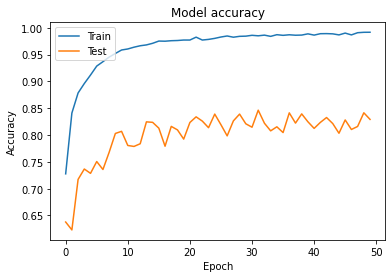

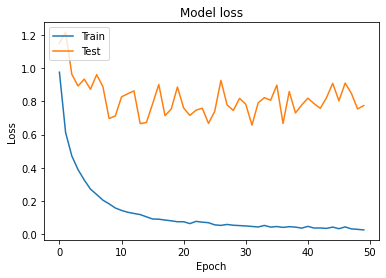

In [115]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()